# Association Rules for trading in R

This notebook uses the concepts of personalization and Association Rules to mine for stock events which appear together.

Just as Milk, Peanut Butter, Jelly, and Bread frequently occur together, events in the stock market occur together in various combinations. By converting stock price from a continuous variable to a descrite variable (a 'factor' in R or a 'category' in python), we can treat these events like items in the apriori algorithm. 

We will get the stock data from Quandl. You can register for a free account to access a lot of data with a key. My key has been removed from this notebook so you will need to provide a your own key to execute the cells. 

Author: Kyle Jones, Solutions Architect

Date: December 13, 2019

# Preparing the envirnment
* Installing and loading the 'arules' library

In [1]:
install.packages(c('arules', 'arulesViz'))

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [2]:
library(arules)

Loading required package: Matrix

Attaching package: ‘arules’

The following objects are masked from ‘package:base’:

    abbreviate, write



In [3]:
library(arulesViz)

Loading required package: grid
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'seriation':
  method         from 
  reorder.hclust gclus


# Using the stock categories

We import the dataset of stock data. 

In [4]:
df = read.transactions('bp_stock.csv', format = 'basket', sep = ",", rm.duplicates = FALSE)

Warning message in asMethod(object):
“removing duplicated items in transactions”

In [5]:
head(df)

transactions in sparse format with
 6 transactions (rows) and
 17 items (columns)

In [6]:
# We now use the apriori algorithm to build the Association Rules. 
# We can declaire parameters for how many items must appear together in a 
# rule with 'minlen'.

rules <- apriori(df,
                 parameter = list(supp = 0.4, 
                                  conf = 0.9,
                                  minlen=5,
                                  target='rules' # to mine for rules
                                  ))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.9    0.1    1 none FALSE            TRUE       5     0.4      5
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 224 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[17 item(s), 561 transaction(s)] done [0.00s].
sorting and recoding items ... [16 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 5 6 7 8 done [0.00s].
writing ... [510 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


In [7]:
# Having built the rules, we can use 'summary' to get more info. 
summary(rules)

set of 510 rules

rule length distribution (lhs + rhs):sizes
  5   6   7   8 
278 168  56   8 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  5.000   5.000   5.000   5.596   6.000   8.000 

summary of quality measures:
    support         confidence          lift           count      
 Min.   :0.4296   Min.   :0.9058   Min.   :1.672   Min.   :241.0  
 1st Qu.:0.4349   1st Qu.:0.9803   1st Qu.:1.823   1st Qu.:244.0  
 Median :0.4385   Median :0.9879   Median :1.838   Median :246.0  
 Mean   :0.4387   Mean   :0.9858   Mean   :1.833   Mean   :246.1  
 3rd Qu.:0.4421   3rd Qu.:0.9922   3rd Qu.:1.845   3rd Qu.:248.0  
 Max.   :0.4563   Max.   :1.0000   Max.   :1.875   Max.   :256.0  

mining info:
 data ntransactions support confidence
   df           561     0.4        0.9

In [8]:
# This is the key code -- we inspect the rules to see which items go together.

# 'lhs' stands for left hand side and can be thought of as the basic condition we want to evaluate. 
# So given the items on the lhs, predict the items in the rhs (right hand side). The intiution is given someone
# has bread, jelly, and milk in their cart, what is the next item they will buy? Peanut butter!

# If the output does not appear on one line, consider making the font smaller with 'CTRL' + '-'

inspect(sort(rules, by='confidence', decreasing = T)[1:5])

    lhs             rhs            support confidence     lift count
[1] {t0_High_H,                                                     
     t0_Open_H,                                                     
     t1_High_H,                                                     
     t1_Open_H}  => {t0_Close_H} 0.4438503          1 1.845395   249
[2] {t0_High_H,                                                     
     t0_Low_H,                                                      
     t0_Open_H,                                                     
     t1_High_H}  => {t0_Close_H} 0.4509804          1 1.845395   253
[3] {t0_High_H,                                                     
     t0_Open_H,                                                     
     t1_High_H,                                                     
     t1_Low_H}   => {t0_Close_H} 0.4402852          1 1.845395   247
[4] {t0_High_H,                                                     
     t0_Open_H,                   

In [9]:
# Now we look for rules containing either whole milk or yogurt

inspect(subset(rules, subset=items %ain% c("t0_Open_H", "t0_High_H", "t0_Low_H", "t0_Close_H") & confidence >.95))

     lhs             rhs            support confidence     lift count
[1]  {t0_High_H,                                                     
      t0_Low_H,                                                      
      t0_Open_H,                                                     
      t1_High_H}  => {t0_Close_H} 0.4509804  1.0000000 1.845395   253
[2]  {t0_Close_H,                                                    
      t0_High_H,                                                     
      t0_Open_H,                                                     
      t1_High_H}  => {t0_Low_H}   0.4509804  0.9960630 1.838129   253
[3]  {t0_Close_H,                                                    
      t0_High_H,                                                     
      t0_Low_H,                                                      
      t1_High_H}  => {t0_Open_H}  0.4509804  0.9844358 1.834779   253
[4]  {t0_Close_H,                                                    
      t0_Low_H,     

In [10]:
# Select rules that have t0 only for the left hand side. This uses the algoroithm to predict the price tomorrow.

rules_subset <- subset(rules, (lhs %ain% c("t0_Open_H", "t0_High_H", "t0_Low_H", "t0_Close_H")), by = "conf")
inspect(rules_subset)

     lhs             rhs            support confidence     lift count
[1]  {t0_Close_H,                                                    
      t0_High_H,                                                     
      t0_Low_H,                                                      
      t0_Open_H}  => {t1_High_H}  0.4509804  0.9166667 1.725671   253
[2]  {t0_Close_H,                                                    
      t0_High_H,                                                     
      t0_Low_H,                                                      
      t0_Open_H}  => {t1_Open_H}  0.4563280  0.9275362 1.728730   256
[3]  {t0_Close_H,                                                    
      t0_High_H,                                                     
      t0_Low_H,                                                      
      t0_Open_H}  => {t1_Low_H}   0.4456328  0.9057971 1.671553   250
[4]  {t0_Close_H,                                                    
      t0_High_H,    

Warning message in plot.rules(rules, interactive = T):
“The parameter interactive is deprecated. Use engine='interactive' instead.”To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.


Interactive mode.
Select a region with two clicks!


ERROR: Error in convertUnit(x, unitTo, "x", "location", "x", "location", valueOnly = valueOnly): 'x' argument must be a unit object


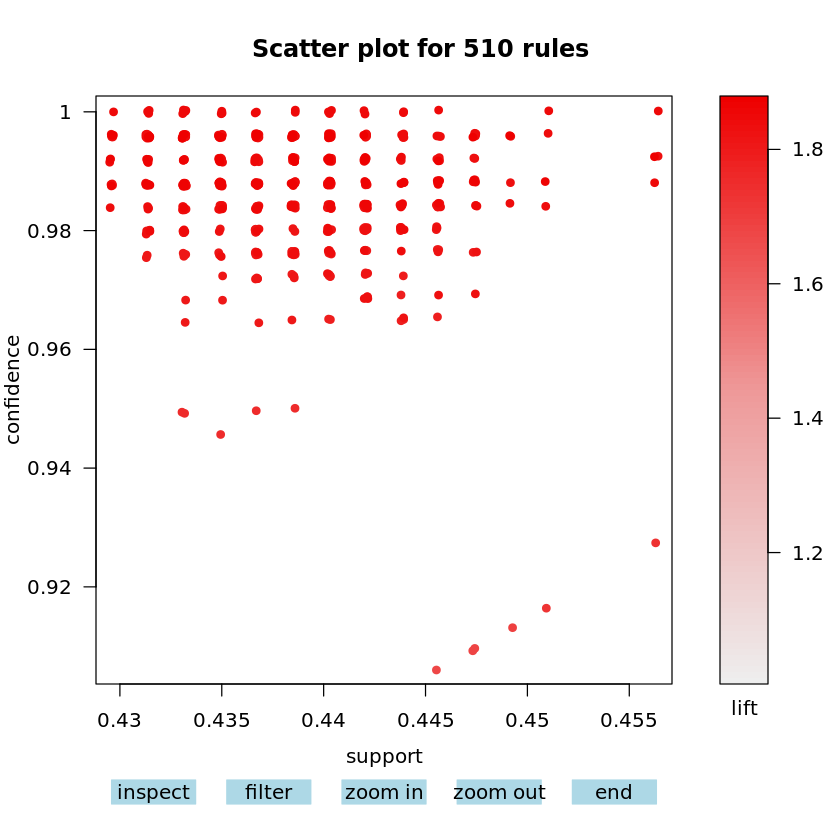

In [11]:
# This plot shows confidence versus support. The items in the upper right quadrant warrent additional attention. 

plot(rules, interactive = T)

# Resources:

Explaintion of dataset: https://www.jdatalab.com/data_science_and_data_mining/2018/10/10/association-rule-transactions-class.html

Example: https://rpubs.com/sbushmanov/180410

Example: http://r-statistics.co/Association-Mining-With-R.html